## Introduction to Geopandas

<center>
<img src="images/vector_head.png" width=200 align="center" />
</center>

### Importing geospatial data

Geospatial data is available from specific GIS file formats or data stores, like ESRI shapefiles, GeoJSON files, geopackage files, PostGIS (PostgreSQL) database ...

In order to read, write and manipulate geospatial data we can use the GeoPandas library to read many of those GIS file formats.

gpd.read_file is the workhorse for reading GIS files. It leverages the fiona package.

In order to dive deeper into geopnadas we first need data. For this purpouse we will use the Natural Earth dataset

"Natural Earth is a public domain map dataset available at 1:10m, 1:50m, and 1:110 million scales. Featuring tightly integrated vector and raster data, with Natural Earth you can make a variety of visually pleasing, well-crafted maps with cartography or GIS software."* 

A subset comes bundled with GeoPandas and is accessible from the gpd.datasets module. We'll use it as a helpful global base layer map.

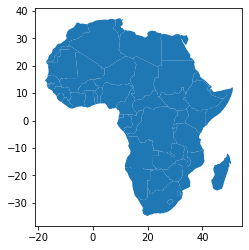

In [2]:
import geopandas as gpd

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
africa = world[world['continent']=='Africa']
africa.plot()

Let’s see what datatype is our ‘data’

In [ ]:
# View object type
type(world)

If you've never seen a **GeoDataFrame**, it is quite simple: 

- A **GeoDataFrame** is similar to a normal **DataDrame** in **Pandas** 

- **Only difference**: it has a 'geometry' column 

- it comes additional functionality for working with geospatial data. 

<center>
<img src="images/geoframe.png" width=500  />
</center>

Let’s take a look at our data and print the first 5 rows using the

In [ ]:
# View  the top 6 lines of attribute table of data
world.head(6)

### Geometry

Vector data contains discrete geometric locations (x, y) known as vertices that define the shape of the spatial object and attributes (also known as properties or characteristics). Spatial vector data can consist of different types, and the 3 fundamental types are: 

<center>
<img src="images/vector.png" width=600  />
</center>

**Points** (0-dimensional): Each individual point is defined by a single x, y coordinate. There can be many points in a vector point file. 
(e.g. GPS-coordinates, city locations, sample points ...)

**Lines** (1-dimensional): A line is composed of a sequence of two or more coordinate pairs. 
(e.g. roads, rivers, contour line ...)

**Polygons** (2-dimensional): A polygon is composed of one or more lines whose starting and ending coordinate pairs are the same. 
(e.g. boundary of countries, lakes, fields ...) 


### The shapely library
Geopandas takes advantage of Shapely’s geometric objects. The geometries for each spatial object is stored in a column called geometry.The individual geometry objects are provided by the shapely library

In [ ]:
print(type(world.geometry[0]))
world.geometry[1]

Of course we can use the shapely library to construct our own vector data

In [ ]:
from shapely.geometry import Point, Polygon, LineString

p = Point(4, 5)
p

In [ ]:
polygon = Polygon([(1, 1), (1,2), (2,2), (2, 1)])
polygon

<center>
<img src="images/gframe_att.png" width=600  />
</center>


And of course we can also create a geopandas dataframe and add some attributes

In [ ]:
gdf = gpd.GeoDataFrame({
      'geometry': Polygon([(1, 1), (1,2), (2,2), (2, 1)]),
      'attribute1': ['Polygon'],
      'attribute2': [0.1]})
gdf

Since spatial data is stored as Shapely objects, it is possible to use all of the functionalities of Shapely

In [ ]:
gdf.geom_type

In [ ]:
gdf.bounds

In [ ]:
gdf.area

In [ ]:
polygon.distance(p)

In [ ]:
gdf.plot(figsize = (2,2))

### Data handling

The fact that our dataset is basically a pandas dataframe with additional information, we can apply pandas functions we already have learned. So we have all the pandas functionality available to use on the geospatial dataset, and to do data manipulations with the attributes and geometry information together.

In [ ]:
world.columns

In [ ]:
africa = world[world['continent']=='Africa']
africa.plot()

In [ ]:
africa['pop_est']

Fortunately, geopandas has already a function which allows us to write our results as Shapefile

In [ ]:
africa.to_file("Data/vector/africa.shp")

Of course GeoPandas provides additional functions for spatial analysis. We can iterate over the selected rows using a specific .iterrows() -function in (geo)pandas and print the area for each polygon:

In [ ]:
for index, row in africa.iterrows():
    poly_area = row['geometry'].area
    print("Polygon area at index {0} is: {1:.3f}".format(africa['name'][index], poly_area))

Beware that these area calculations are in the native degrees units, which is fairly useless

### CRS

A coordinate reference system (CRS) determines how the two-dimensional (planar) coordinates of the geometry objects should be related to actual places on the (non-planar) earth. The EPSG number (“European Petroleum Survey Group”) is a code that tells about the coordinate system of the dataset.You can find a lot of information about different available coordinate reference systems from: www.spatialreference.org

<center>
<img src="images/crs.png" width=800  />
</center>

In [1]:
# View CRS of object
africa.crs

NameError: name 'africa' is not defined

Let’s convert those geometries into Lambert Azimuthal Equal Area projection (EPSG: 3035). Changing the projection is really easy to do in Geopandas with .to_crs() -function. As an input for the function, you should define the column containing the geometries, i.e. geometry in this case, and a epgs value of the projection that you want to use.

In [ ]:
# Reprojecting data
africa_aeac = africa.to_crs('esri:102022')


In [ ]:
africa['geometry'].head()
africa_aeac['geometry'].head()

In [ ]:
import matplotlib.pyplot as plt

africa.plot(facecolor='gray');
plt.title("WGS84 projection");
plt.tight_layout()

africa_aeac.plot(facecolor='blue');
plt.title("Africa Albers Equal Area Conic");
plt.tight_layout()

Now we can calculate the actual area for each country. This time we append the result to the dataframe

In [ ]:
africa_aeac['area'] = africa_aeac.area
africa_aeac

Let’s find out which country is the smallest and which is the biggest

In [ ]:
# Maximum area
max_area = africa_aeac['area'].max()

# Mean area
min_area = africa_aeac['area'].min()

print("Max area: %s\nMean area: %s" % (round(max_area, 2), round(min_area, 2)))


But which country is now the biggest/smallest. Take a guess.

In [ ]:
max_area_country = africa_aeac[africa_aeac['area'] == max_area]
max_area_country

In [ ]:
min_area_country = africa_aeac[africa_aeac['area'] == min_area]
min_area_country

Of course we can now also add the temperature data we used in the last session

In [ ]:
import pandas as pd
temp = pd.read_csv('Data/non-spatial/GlobalLandTemperatures/GlobalLandTemperaturesByCountry_2000_2013.csv')

temp['name'] = temp['Country']
africa_temp = africa.merge(temp, on='name')

In [ ]:
africa_temp_20130601 = africa_temp[africa_temp['dt'] == '2013-02-01'].plot(column='AverageTemperature')

In [ ]:
africa_temp.to_file('Data/vector/africa_temp.shp')

### Spatial relations

Spatial relationships are important aspect of geospatial data if we want to know how two spatial objects relate to each other. 

<br>

<center>
<img src="images/spatialrelation.png" width=800  />
</center>

In [ ]:
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
cities

In [ ]:
africa.plot()

In the next step we will clip our cities dataset to the african continent and 

In [ ]:
cities_africa = gpd.clip(cities, africa)
cities_africa.plot()

In [ ]:
#import geopandas as gpd
#africa = gpd.read_file("./Data/vector/africa.shp")

In [ ]:
from shapely.geometry import LineString

uganda = africa.loc[africa['name'] == 'Uganda', 'geometry'].squeeze()

kampala = cities_africa.loc[cities_africa['name'] == 'Kampala', 'geometry'].squeeze()
bamako = cities_africa.loc[cities_africa['name'] == 'Bamako', 'geometry'].squeeze()

In [ ]:
line = LineString([kampala, bamako])


gpd.GeoSeries([uganda, kampala, bamako , line]).plot(cmap='tab10')

Kampala, the capital of Uganda, is thus located within Uganda. This is a spatial relationship, and we can test this using the individual shapely geometry objects as follow:

In [ ]:
kampala.within(uganda)

And using the reverse, Uganda contains Kampala:

In [ ]:
uganda.contains(kampala)

Of course many other spatial relations can be tested, e.g.

In [ ]:
uganda.contains(bamako)
bamako.within(uganda)
uganda.contains(line)
line.intersects(uganda)

The same methods that are available on individual shapely geometries as we have seen above, are also available as methods on GeoSeries / GeoDataFrame objects.

In [ ]:
africa.contains(kampala)
africa[africa.contains(kampala)]

Overview of the different functions to check spatial relationships:

- `equals`
- `contains`
- `crosses`
- `disjoint`
- `intersects`
- `overlaps`
- `touches`
- `within`
- `covers`


Shapely and GeoPandas aslo provide spatial operations that return new geometric objects.
Let's construct a buffer around Kampala:

In [ ]:
kampala.buffer(2)

In [ ]:
gpd.GeoSeries([uganda, kampala.buffer(2)])

In [ ]:
gpd.GeoSeries([uganda, kampala.buffer(2)]).plot(alpha=0.5, cmap='tab10')

and now take the intersection, union or difference of those two polygons:

In [ ]:
#kampala.buffer(2).intersection(uganda)

#kampala.buffer(2).union(uganda)

kampala.buffer(2).difference(uganda)

## Visualization

Now we know how to use geopandas it is time to create some maps. The most simple way to create a map is to used the in-built plot function

In [ ]:
import geopandas as gpd

africa = gpd.read_file('Data/vector/africa.shp')
africa.plot(figsize=(10,10))

But let's create a more advanced map. Therefor we can use the matplotlib library

In [ ]:
africa

In [ ]:
import matplotlib.pyplot as plt

# set the range for the choropleth
vmin, vmax = africa.pop_est.min() , africa.pop_est.max()

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))

# create map
africa.plot(column='pop_est', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

# remove the axis
ax.axis('off')

# add a title
ax.set_title('Estimated population', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})

# create an annotation for the  data source
ax.annotate('Source: Natural Earth',
           xy=(0.1, .08), xycoords='figure fraction',
           horizontalalignment='left', verticalalignment='top',
           fontsize=10, color='#555555')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

# this will save the figure as a high-res png. you can also save as svg
fig.savefig('testmap.png', dpi=300)

The geoplot packages provides some additional functionality compared to the basic .plot() method on GeoDataFrames



In [ ]:
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={
    'projection': gcrs.Orthographic(central_latitude=0, central_longitude=0)
})
geoplot.choropleth(africa, hue='pop_est', projection=gcrs.Orthographic(), ax=ax,
                   linewidth=0.5, edgecolor='white')
ax.set_global()
ax.outline_patch.set_visible(True)
ax.coastlines()

## Interactive web-based visualizations

There are nowadays many libraries that target interactive web-based visualizations:

- Bokeh: https://bokeh.pydata.org/en/latest/docs/gallery/texas.html
- GeoViews (other interface to Bokeh/matplotlib): http://geo.holoviews.org
- Altair: https://altair-viz.github.io/gallery/choropleth.html
- Plotly: https://plot.ly/python/#maps
    ...


Another popular javascript library for online maps is Leaflet.js, and this has python bindings in the folium and ipyleaflet packages. We basically give it minimal instructions, JS does loads of work in the background and we get some very, very cool maps. 

In [ ]:
import ipyleaflet

m = ipyleaflet.Map(center=[0, 0], zoom=2)

layer = ipyleaflet.GeoJSON(data=africa.__geo_interface__)
m.add_layer(layer)
m

In [ ]:
import ipyleaflet

m = ipyleaflet.Map(center=[0, 0], zoom=10)

layer = ipyleaflet.GeoJSON(data=africa.__geo_interface__)
m.add_layer(layer)
m

In [ ]:
from ipyleaflet import Map, basemaps, basemap_to_tiles

m = ipyleaflet.Map(center=[0, 0], zoom=2, basemap=basemap_to_tiles(basemaps.NASAGIBS.ModisTerraTrueColorCR, "2020-04-08"))

layer = ipyleaflet.GeoJSON(data=africa.__geo_interface__)
m.add_layer(layer)
m

In [ ]:
import folium

m = folium.Map([0, 0], zoom_start=2, tiles="OpenStreetMap")
folium.Choropleth(geo_data=africa, data=africa, columns=['name', 'pop_est'],
             key_on='feature.properties.name', fill_color='BuGn', highlight=True).add_to(m)
m

## Advanced Examples

Interactive Weather Maps in Python

Source: https://medium.com/@plotlygraphs/how-to-create-2d-and-3d-interactive-weather-maps-in-python-and-r-77ddd53cca8

In [ ]:
import plotly
import plotly.offline as py
from plotly.graph_objs import *
py.init_notebook_mode(connected=False)
from plotly.graph_objs.layout import *
from plotly.graph_objs.scatter import *
import numpy as np           
from scipy.io import netcdf  
from mpl_toolkits.basemap import Basemap


f_path = 'Data/raster/compday.uD1lrjCi2B.nc' 

# Retrieve data from NetCDF file
with netcdf.netcdf_file(f_path, 'r') as f:
    lon = f.variables['lon'][::]    # copy as list
    lat = f.variables['lat'][::-1]  # invert the latitude vector -> South to North
    air = f.variables['prate'][0,::-1,:]  # squeeze out the time dimension, 
                                        # invert latitude index
# Shift 'lon' from [0,360] to [-180,180], make numpy array
tmp_lon = np.array([lon[n]-360 if l>=180 else lon[n] 
                   for n,l in enumerate(lon)])  # => [0,180]U[-180,2.5]

i_east, = np.where(tmp_lon>=0)  # indices of east lon
i_west, = np.where(tmp_lon<0)   # indices of west lon
lon = np.hstack((tmp_lon[i_west], tmp_lon[i_east]))  # stack the 2 halves

# Correspondingly, shift the 'precip' array
precip_air = np.array(air)
air = np.hstack((precip_air[:,i_west], precip_air[:,i_east]))
trace1 = Contour(
    z=air,
    x=lon,
    y=lat,
    colorscale= [[0.0, '#543005'], [0.07692307692307693, '#7f4909'], [0.15384615384615385, '#a76a1d'], [0.23076923076923078, '#c99545'], [0.3076923076923077, '#e1c582'], [0.38461538461538464, '#f2e2b8'], [0.46153846153846156, '#f6f0e2'], [0.5384615384615384, '#e4f1ef'], [0.6153846153846154, '#bce6e0'], [0.6923076923076923, '#86cfc4'], [0.7692307692307693, '#4ea79e'], [0.8461538461538461, '#218078'], [0.9230769230769231, '#015c53'], [1.0, '#003c30']],
    zauto=False,  # custom contour levels
    zmin=-3,      # first contour level
    zmax=3,        # last contour level  => colorscale is centered about 0
    
colorbar= {
    "borderwidth": 0, 
    "outlinewidth": 0, 
    "thickness": 15, 
    "tickfont": {"size": 14}, 
    "title": "mm/day"}, #gives your legend some units                                                                     

contours= {
    "end": 2.5, 
    "showlines": False, 
    "size": 0.25, #this is your contour interval
    "start": -2.5}     
    
)    
# Make shortcut to Basemap object, 
# not specifying projection type for this example
m = Basemap() 

# Make trace-generating function (return a Scatter object)
def make_scatter(x,y):
    return Scatter(
        x=x,
        y=y,
        mode='lines',
        line=Line(color="black"),
        name=' '  # no name on hover
    )

# Functions converting coastline/country polygons to lon/lat traces
def polygons_to_traces(poly_paths, N_poly):
    ''' 
    pos arg 1. (poly_paths): paths to polygons
    pos arg 2. (N_poly): number of polygon to convert
    '''
    # init. plotting list
    data = dict(
        x=[],
        y=[],
        mode='lines',
        line=Line(color="black"),
        name=' '
    )

    for i_poly in range(N_poly):
        poly_path = poly_paths[i_poly]
        
        # get the Basemap coordinates of each segment
        coords_cc = np.array(
            [(vertex[0],vertex[1]) 
             for (vertex,code) in poly_path.iter_segments(simplify=False)]
        )
        
        # convert coordinates to lon/lat by 'inverting' the Basemap projection
        lon_cc, lat_cc = m(coords_cc[:,0],coords_cc[:,1], inverse=True)
    
        
        # add plot.ly plotting options
        data['x'] = data['x'] + lon_cc.tolist() + [np.nan]
        data['y'] = data['y'] + lat_cc.tolist() + [np.nan]
        
        # traces.append(make_scatter(lon_cc,lat_cc))
     
    return [data]

# Function generating coastline lon/lat traces
def get_coastline_traces():
    poly_paths = m.drawcoastlines().get_paths() # coastline polygon paths
    N_poly = 91  # use only the 91st biggest coastlines (i.e. no rivers)
    return polygons_to_traces(poly_paths, N_poly)

# Function generating country lon/lat traces
def get_country_traces():
    poly_paths = m.drawcountries().get_paths() # country polygon paths
    N_poly = len(poly_paths)  # use all countries
    return polygons_to_traces(poly_paths, N_poly)

# Get list of of coastline, country, and state lon/lat traces
traces_cc = get_coastline_traces()+get_country_traces()
data = Data([trace1]+traces_cc)

title = u"Surface Precipitation Rate Anomalies<br>Dec 2017-Jan 2018"

anno_text = "Data courtesy of \
<a href='http://www.esrl.noaa.gov/psd/data/composites/day/'>\
NOAA Earth System Research Laboratory</a>"

axis_style = dict(
    zeroline=False,
    showline=False,
    showgrid=False,
    ticks='',
    showticklabels=False,
)

layout = Layout(
    title=title,
    showlegend=False,
    hovermode="closest",        # highlight closest point on hover
    xaxis=XAxis(
        axis_style,
        range=[lon[0],lon[-1]]  # restrict y-axis to range of lon
    ),
    yaxis=YAxis(
        axis_style,
    ),
    annotations=Annotations([
        Annotation(
            text=anno_text,
            xref='paper',
            yref='paper',
            x=0,
            y=1,
            yanchor='bottom',
            showarrow=False
        )
    ]),
    autosize=False,
    width=1200,
    height=800,
)

fig = Figure(data=data, layout=layout)

py.iplot(fig, filename="NCEP Precipitation")

Interactive Map of the NYC bicycle sharing program

Source:https://blog.prototypr.io/interactive-maps-with-python-part-1-aa1563dbe5a9

In [ ]:
import pandas as pd
bike_data = pd.read_csv("Data/non-spatial/citibike-tripdata_example.csv") 
bike_data

In [ ]:
bike_data["starttime"] = pd.to_datetime(bike_data["starttime"])
bike_data["stoptime"] = pd.to_datetime(bike_data["stoptime"])
bike_data["hour"] = bike_data["starttime"].map(lambda x: x.hour)

In [ ]:
def get_trip_counts_by_hour(selected_hour):
    # make a DataFrame with locations for each bike station
    locations = bike_data.groupby("start station id").first()
    locations = locations.loc[:, ["start station latitude",
                                 "start station longitude",
                                 "start station name"]]
    
    #select one time of day
    subset = bike_data[bike_data["hour"]==selected_hour]
    
    # count trips for each destination
    departure_counts =  subset.groupby("start station id").count()
    departure_counts = departure_counts.iloc[:,[0]]
    departure_counts.columns= ["departure count"]
    
    # count trips for each origin
    arrival_counts =  subset.groupby("end station id").count().iloc[:,[0]]
    arrival_counts.columns= ["arrival count"]

    #join departure counts, arrival counts, and locations
    trip_counts = departure_counts.join(locations).join(arrival_counts)
    return trip_counts

# print a sample to check our code works
get_trip_counts_by_hour(6).head()

def plot_station_counts(trip_counts):
    # generate a new map
    folium_map = folium.Map(location=[40.738, -73.98],
                            zoom_start=13,
                            tiles="CartoDB dark_matter",
                            width='50%')

    # for each row in the data, add a cicle marker
    for index, row in trip_counts.iterrows():
        # calculate net departures
        net_departures = (row["departure count"]-row["arrival count"])
        
        # generate the popup message that is shown on click.
        popup_text = "{}<br> total departures: {}<br> total arrivals: {}<br> net departures: {}"
        popup_text = popup_text.format(row["start station name"],
                          row["arrival count"],
                          row["departure count"],
                          net_departures)
        
        # radius of circles
        radius = net_departures/20
        
        # choose the color of the marker
        if net_departures>0:
            # color="#FFCE00" # orange
            # color="#007849" # green
            color="#E37222" # tangerine
        else:
            # color="#0375B4" # blue
            # color="#FFCE00" # yellow            
            color="#0A8A9F" # teal
        
        # add marker to the map
        folium.CircleMarker(location=(row["start station latitude"],
                                      row["start station longitude"]),
                            radius=radius,
                            color=color,
                            popup=popup_text,
                            fill=True).add_to(folium_map)
    return folium_map

In [ ]:
# plot net departures at 9AM

trip_counts = get_trip_counts_by_hour(9)
plot_station_counts(trip_counts)

### Additional Content: Retrieving OpenStreetMap data

In [ ]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

place_name = "Maxvorstadt ,Munich, Germany"
graph = ox.graph_from_place(place_name, network_type='drive')
nodes, edges = ox.graph_to_gdfs(graph)
buildings = ox.footprints_from_place(place_name) 
university = ox.pois_from_place(place_name, amenities=['university'])


In [ ]:
fig, ax = plt.subplots()
edges.plot(ax=ax, facecolor='black')
buildings.plot(ax=ax, facecolor='khaki', alpha=0.7)
university.plot(ax=ax, facecolor='red', alpha=0.7)

plt.tight_layout()

In [ ]:
pois = university[(university['name'] == 'Lehrstuhl für Kartographie') | (university['name'] == 'Technische Universität München / Modelierung Räumlicher Mobilität')]


In [ ]:
fig, ax = plt.subplots()
edges.plot(ax=ax, facecolor='black')
pois.plot(ax=ax, facecolor='red')

plt.tight_layout()

### Additional Conetent 2: Networks 

In [ ]:
orig_xy = (pois.iloc[0].geometry.y, pois.iloc[0].geometry.x)
target_xy = (pois.iloc[1].geometry.y,pois.iloc[1].geometry.x)
orig_node = ox.get_nearest_node(graph, orig_xy, method='euclidean')
target_node = ox.get_nearest_node(graph, target_xy, method='euclidean')

In [ ]:
o_closest = nodes.loc[orig_node]
t_closest = nodes.loc[target_node]

In [ ]:
od_nodes = gpd.GeoDataFrame([o_closest, t_closest], geometry='geometry', crs=nodes.crs)
od_nodes.head()

In [ ]:
route = nx.shortest_path(G=graph, source=orig_node, target=target_node, weight='length')
print(route)

In [ ]:
fig, ax = ox.plot_graph_route(graph, route, origin_point=orig_xy, destination_point=target_xy)

## Exercise

- Import the nigeria.csv (Data/non-spatial)dataset and create a GeoPandasDataFrame (Hint: don't forget to set the CRS)
- How many features are there in the dataset? 
- Make a quick plot of the stations dataset.
- Create a nice map showing the location of fires
- Make a histogram showing the Fire Radiative Power for all fires
- Import the protected areas layer (Data/vector/nigeria)
- How many fires occured in protected areas
- In which protected areas did fires occure
- Create a heatmap showing die fire density for nigeria